# Tagged forward protons

In central (semi)exclusive events, scattered protons might remain intact and can be detected by the Precision Proton Spectrometer (PPS). The interacting photons and the proton 4-momentum is given by:

\begin{equation}
\begin{split}
P^\text{proton}_{initial} &= P^\text{proton}_{final} + P^\text{photon} \\
P^\text{photon} &= P^\text{proton}_{initial} - P^\text{proton}_{final} = P_\text{BEAM} - P^\text{forward-proton}
\end{split}\label{eq:eq0}
\end{equation}

We can define proton longitudinal momentum loss by:
\begin{equation}
\begin{split}
\xi &= \left| \left( P^\text{proton}_{initial} - P^\text{proton}_{final} \right) / P^\text{proton}_{initial} \right| = 1-\Delta p/E_\text{beam}
\end{split}\label{eq:eqxi}
\end{equation}

Then four-momentum of incoming protons and outgoing proton (as well as for the interacting photon) can be expressed as (note we neglect protons mass since $E_\text{beam}>>m_p$):

\begin{equation}
\begin{split}
P^\text{proton}_{initial} &= \left( E_\text{beam}, 0, 0, \pm E_\text{beam} \right) \\
P^\text{proton}_{final} &= \left( (1-\xi)E_\text{beam}, E_\text{beam}\cdot\theta^*_{X}, E_\text{beam}\cdot\theta^*_{Y}, \pm (1-\xi)E_\text{beam} \right) \\
P^\text{photon} &= \left( \xi E_\text{beam}, -E_\text{beam}\cdot\theta^*_{X}, -E_\text{beam}\cdot\theta^*_{Y}, \pm \xi E_\text{beam} \right) 
\end{split}\label{eq:eq4momentum}
\end{equation}

Where $\left(\xi, \theta^*_{X}, \theta^*_{Y}\right)$ are variables measured by the PPS.

The two proton, or two photon (and in case of di-lepton final state -- the two lepton) invariant mass can be calculated from (remember $P_\text{proton1+proton2}=-P_\text{photon1+photon2}=-P_\text{lepton1+lepton2}$):

\begin{equation}
\begin{split}
m^2_{pp} &= \left( P^\text{photon1} + P^\text{photon2} \right)^2 \\
 &= | \left( (\xi_1 + \xi_2)E_{beam},0 ,0 ,(\xi_1 - \xi_2)E_{beam} \right) |^2 \\
 &= (\xi_1 + \xi_2)^2 E^2_{beam} - (\xi_1 - \xi_2)^2 E^2_{beam} \\
 &= 4\xi_1\xi_2E^2_{beam} \\
 &= s\xi_1\xi_2
\end{split}\label{eq:invmass}
\end{equation}


Where $\sqrt{s} = \left(2E_\text{beam}\right)$ is the center of mass energy, then we can express the di-lepton invarint mass and rapidity as:

\begin{equation}
\begin{split}
m_{\ell\ell} &= \sqrt{s\xi_1\xi_2}\\
Y_{\ell\ell} &= \frac{1}{2}\log(\xi_1/\xi_2),
\end{split}\label{eq:eq1}
\end{equation}


In case of single dissociation (when only one proton remains intact), we can reconstruct proton momentum loss from the kinematics measured in the central detector: di-lepton mass $m_{\ell\ell}$ and pseudo-rapidity of the leptons $\eta_{\ell\pm}$, using the following formula:

\begin{equation}
\xi_\pm = \frac{1}{\sqrt{s}}[p_T(\ell+)e^{\pm\eta(\ell+)} + p_T(\ell-)e^{\pm\eta(\ell-)}] 
\label{eq:eq2}
\end{equation}

In [1]:
#start with standard python imports
# if the import of mplhep fails follow instructions in Event-selection-optimization.ipynb
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.colors import LogNorm

In [2]:
#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

In [3]:
#Execute this lines to copy the files to local folder:
DATAPATH='root://cmseos.fnal.gov//store/user/cmsdas/2022/long_exercises/pps-exclusive-dilepton/h5py'
PATH='output'
files=[
    'output-GGToMuMu_Elastic_v0.h5',
    'output-MC13TeV_DYToLL50toInf_MLM_v0.h5',
    'output-UL2018B-Mu.h5'
      ]
for f in files:
    !xrdcopy {DATAPATH}/{f} {PATH}/.

### Loading the data (signal and background)

Similarlt to [Event-selection-optimization.ipynb](https://nbviewer.jupyter.org/github/cmsdas/pps-long-exercise/blob/master/Event-selection-optimization.ipynb) we will use `h5py` files of the simulated signal events:

In [4]:
def GetData(filename):
    
    """ opens a summary file and converts it to a pandas dataframe """
    
    with h5py.File(filename, 'r') as f:
        dset = f['protons']
        dset_columns = f['columns']
        columns = list( dset_columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        return pd.DataFrame( dset, columns=columns_str )
    
    return pd.DataFrame()

In [5]:
#Select stream (Electrons of Muons)
stream='Mu'  # chose 'El' or 'Mu'

In [7]:
#load the signal samples into the dataframes (takes some time)
df_signal = GetData(PATH+'/output-GGTo{}_Elastic_v0.h5'.format('EE' if stream=='El' else 'MuMu'))

In [8]:
#Load the data samples into the dataframes (takes some time)
df_data={}
eras=['B']
#eras=['B','C','D','E','F'] # uncomment to process all data
for x in eras:
    df_data[x] = GetData(PATH+'/output-UL2018{}-{}.h5'.format(x,stream))
    df_data[x]['era']=x
    print('output-UL2018{}-{} shape = {}'.format(x,stream,df_data[x].shape))

#combine all into a single one
df_data=pd.concat([df_data[x] for x in eras])

output-UL2018B-Mu shape = (788322, 21)


### Exploring the data files

Plot the content of the files:

In [9]:
def PrintInfoFromDF(df):
    print('Print all branches:')
    print(df.keys())
    print('Size of the data is ',df.shape)

In [10]:
PrintInfoFromDF(df_signal)
PrintInfoFromDF(df_data)

Print all branches:
Index(['Run', 'EventNum', 'MultiRP', 'Arm', 'RPId1', 'Xi', 'T', 'ThX', 'ThY',
       'Lep0Pt', 'Lep0Eta', 'Lep0Phi', 'Lep1Pt', 'Lep1Eta', 'Lep1Phi',
       'InvMass', 'PV_ndof', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'],
      dtype='object')
Size of the data is  (308339, 20)
Print all branches:
Index(['Run', 'EventNum', 'MultiRP', 'Arm', 'RPId1', 'Xi', 'T', 'ThX', 'ThY',
       'Lep0Pt', 'Lep0Eta', 'Lep0Phi', 'Lep1Pt', 'Lep1Eta', 'Lep1Phi',
       'InvMass', 'PV_ndof', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus', 'era'],
      dtype='object')
Size of the data is  (788322, 21)


## Tagged protons

In central exclusive events, protons remain intact and can be detected in the PPS. In addition to the forward protons from the exclusive production, as discussed in [intro video](https://videos.cern.ch/record/2730189/embed) we can also have protons originating from proton-proton diffractive collision (typically single diffractive events). In high pileup conditions, the main background will be the combinatorial background - inclusive production of lepton pairs + two forward protons from pileup interactions. 

As discussed in the [short exercise on Tagged protons](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolCERN2020TaggedProtonsShortExercise), PPS detectors are sensitive in range of $\xi\in\left(0.03,0.15\right)$. In this exercise, we will study how we can improve our sensitivity to central (semi)exclusive events based on PPS information.

### Read the forward protons data

The forward detectors are located ~200m from the CMS detector on both sides. The positive, negative direction of the beam ($\hat{z}-axis$) is related to different arm number and detector index. The full numbering scheme is shown below:

<img src="img/rp_numbering_scheme_PPSadapted.png" alt="PPS numbers" style="width: 700px;"/>

Therefore if we wish to select tagged protons in a positive direction, we will use:
```python
msk1 = mask & ( dataframe["MultiRP"] == 1) & ( dataframe["Arm"] == 0 )
```
while for the negative direction protons, we will select:
```python
msk2 = mask & ( dataframe["MultiRP"] == 1) & ( dataframe["Arm"] == 1 )
```

NOTE: in 2017 configuration, proton reconstruction using the `MultiRP` method can only have 0 or 1 reconstructed protons. Events with $\geq2$ tagged protons will be counted as 0.  

<b>TASK A</b>

Calculate number of events with 0, 1 and 2 tagged protons in the data

HINT: Use the pandas [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) command to count events with tagged protons
```python
Nprotons = [gr['MultiRP'].sum() for name, gr in df.groupby('EventNum')]
```

In [12]:
#compute number of events with tagged protons in the signal sample
Nprotons = [gr['MultiRP'].sum() for name, gr in df_signal.groupby('EventNum')]
print('0 proton events = '+str(sum([x==0 for x in Nprotons]))+
      ', 1 proton events = '+str(sum([x==1 for x in Nprotons]))+
      ', 2 proton events = '+str(sum([x==2 for x in Nprotons]))+
      ', 3 proton events = '+str(sum([x==3 for x in Nprotons])))


0 proton events = 725, 1 proton events = 3360, 2 proton events = 2780, 3 proton events = 1963


In [13]:
#compute number of events with tagged protons in the data (df_data):
#######################
#   ADD YOUR CODE HERE 
#######################


0 proton events = 15808, 1 proton events = 47881, 2 proton events = 33703, 3 proton events = 17166


In the next block we will inspect this correlation

<b>TASK B</b>

Write a function that will produce a 2D scatter plot of measured $\xi$ in the forward detector and the reconstructed $\xi(\ell\ell)$ using Eq. \ref{eq:eq2}.


HINT: Use the block below to add a new column to the dataframe with reconstructed $\xi$ named `recXi_pos` and `recXi_neg`
```python
df_signal['recXi_pos'] = USE FORMULA (2) TO COMPUTE POSSITIVE XIs
df_signal['recXi_neg'] = USE FORMULA (2) TO COMPUTE NEGATIVE XIs
```


In [ ]:
def ComputeXi(dataframe):
    
    """ computes the proton csi based on the central system kinematics"""

    sqrts=13000.
    dataframe['recXi_pos'] = 1  # USE FORMULA (2)
    dataframe['recXi_neg'] = 1  # USE FORMULA (2)
     
    return dataframe

#if you are stuck uncomment the following line to load the solution
# %load ./snippets/DataInspectionTask2.py

The code below `Plot2DScatter(dataframe)` will plot 2D scatter plot between reconstructed $\xi$ from the two leptons and $\xi$ measured by the forward detectors:

In [16]:
def Plot2DScatter(dataframe, mask = [], proton_selection = "MultiRP"):

    """Shows the corelation between the xi reconstucted from the PPS system and from the central dilepton system"""
    
    if not mask.empty and len(mask) != dataframe.shape[0]:
        print('Error: bad mask, check if the mask corresponds to the dataframe')
        return
    
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1 = mask & ( dataframe["MultiRP"] == 0) & ( dataframe["RPId1"] == 23 )
        msk2 = mask & ( dataframe["MultiRP"] == 0) & ( dataframe["RPId1"] == 123 )
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1 = mask & ( dataframe["MultiRP"] == 1 ) & ( dataframe["Arm"] == 0 )
        msk2 = mask & ( dataframe["MultiRP"] == 1 ) & ( dataframe["Arm"] == 1 )
 
    print ( len(dataframe[ "Xi" ][ msk1 ]), len(dataframe[ "Xi" ][ msk2 ]) )

    fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
    axes[0,0].plot( dataframe[ "Xi" ][ msk1 ], dataframe[ "recXi_pos" ][ msk1 ], 'ko' )
    axes[0,1].plot( dataframe[ "Xi" ][ msk2 ], dataframe[ "recXi_neg" ][ msk2 ], 'ko' )
    _,_,_, im = axes[1,0].hist2d( dataframe[ "Xi" ][ msk1 ], dataframe[ "recXi_pos" ][ msk1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
    fig.colorbar(im, ax=axes[1,0])
    _,_,_, im = axes[1,1].hist2d( dataframe[ "Xi" ][ msk2 ], dataframe[ "recXi_neg" ][ msk2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
    fig.colorbar(im, ax=axes[1,1])

    for i in range(2):
        for j in range(2):
            #aux lines
            axes[i,j].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
            axes[i,j].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
            axes[i,j].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
            axes[i,j].set_xlim(0.,0.15)
            axes[i,j].set_ylim(0.,0.15)
            sgn='+' if j==0 else '-'
            axes[i,j].set_xlabel(r'$\xi_{%s}$ (PPS)'%(sgn))
            axes[i,j].set_ylabel(r'$\xi_{%s}$ (dileptons)'%(sgn))

### Correlation plots - signal:

Check your results with ploting correlation plots for the signal (exclusive) events:

39850 32115


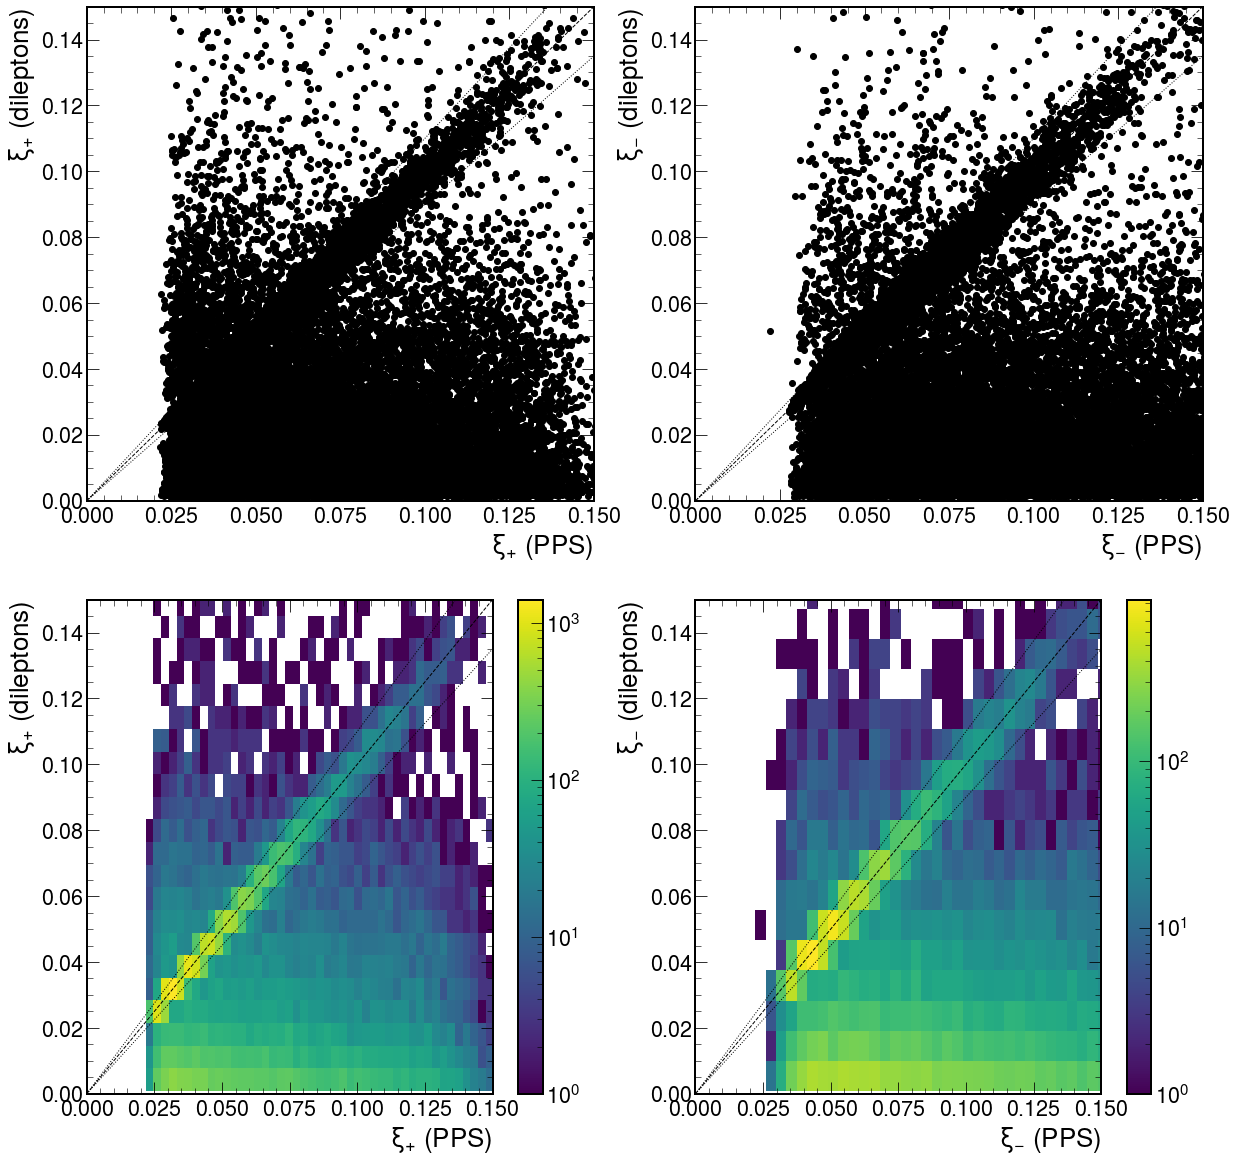

In [25]:
#before the start, lets mask events with high invariant mass, with two leptons produced back to back exclusivelly 
msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["PV_ndof"] <= 10 )

#in addiitonl we will focus only on MultiRP reconstruction
proton_selection = "MultiRP" # "SingleRP" or "MultiRP"

#compute xi
ComputeXi(df_signal)

#plot correlations:
Plot2DScatter(df_signal, mask=msk_excl, proton_selection=proton_selection)

We can also plot the difference betweeen recontructed and measured $\xi$ values in 1D plot. It is easier to mask only

In [19]:
# add new variables to dataframes for possitivle and negative xi's :
mask_pos = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
mask_neg = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )

df_signal['delxi_pos'] = (1 - df_signal[ "Xi" ] / df_signal[ "recXi_pos" ])
df_signal['delxi_neg'] = (1 - df_signal[ "Xi" ] / df_signal[ "recXi_neg" ])

In [26]:
#use plotting function form Event-selection-optimization.ipynb
def PlotFromDF(variable, xmin, xmax, nbins, dataframes, _labels, ax, log=False):
    bins = np.linspace(xmin,xmax,nbins)
    data=[]; labels=[]
    for df, label in zip(dataframes, _labels):
        h, _ = np.histogram(df[variable], bins,density=True)
        data.append(h)
        labels.append(label)
    hep.histplot(data, bins, ax=ax, label=labels)
    hep.cms.label(llabel="Preliminary", rlabel="CMSvDAS 2022", ax=ax)
    ax.legend(); 
    ax.set(xlabel=variable, ylabel='p.d.f.')
    if log: plt.yscale("log")
    plt.savefig(variable+'.png')  

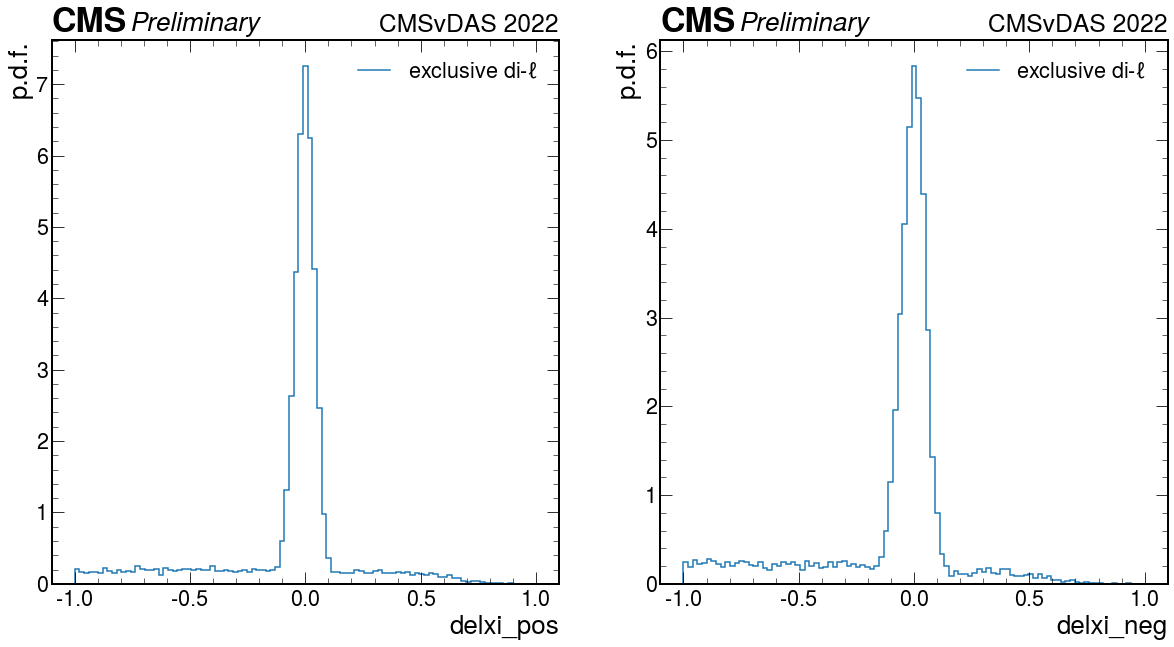

In [27]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
PlotFromDF('delxi_pos',-1,1,100,[df_signal[ mask_pos ]],['exclusive di-$\ell$'],axes[0], log=False)
PlotFromDF('delxi_neg',-1,1,100,[df_signal[ mask_neg ]],['exclusive di-$\ell$'],axes[1], log=False)

### Correlation plots - data:

<b>TASK C</b>

Produce correlation plots now for data events as we did for the signal

403 341


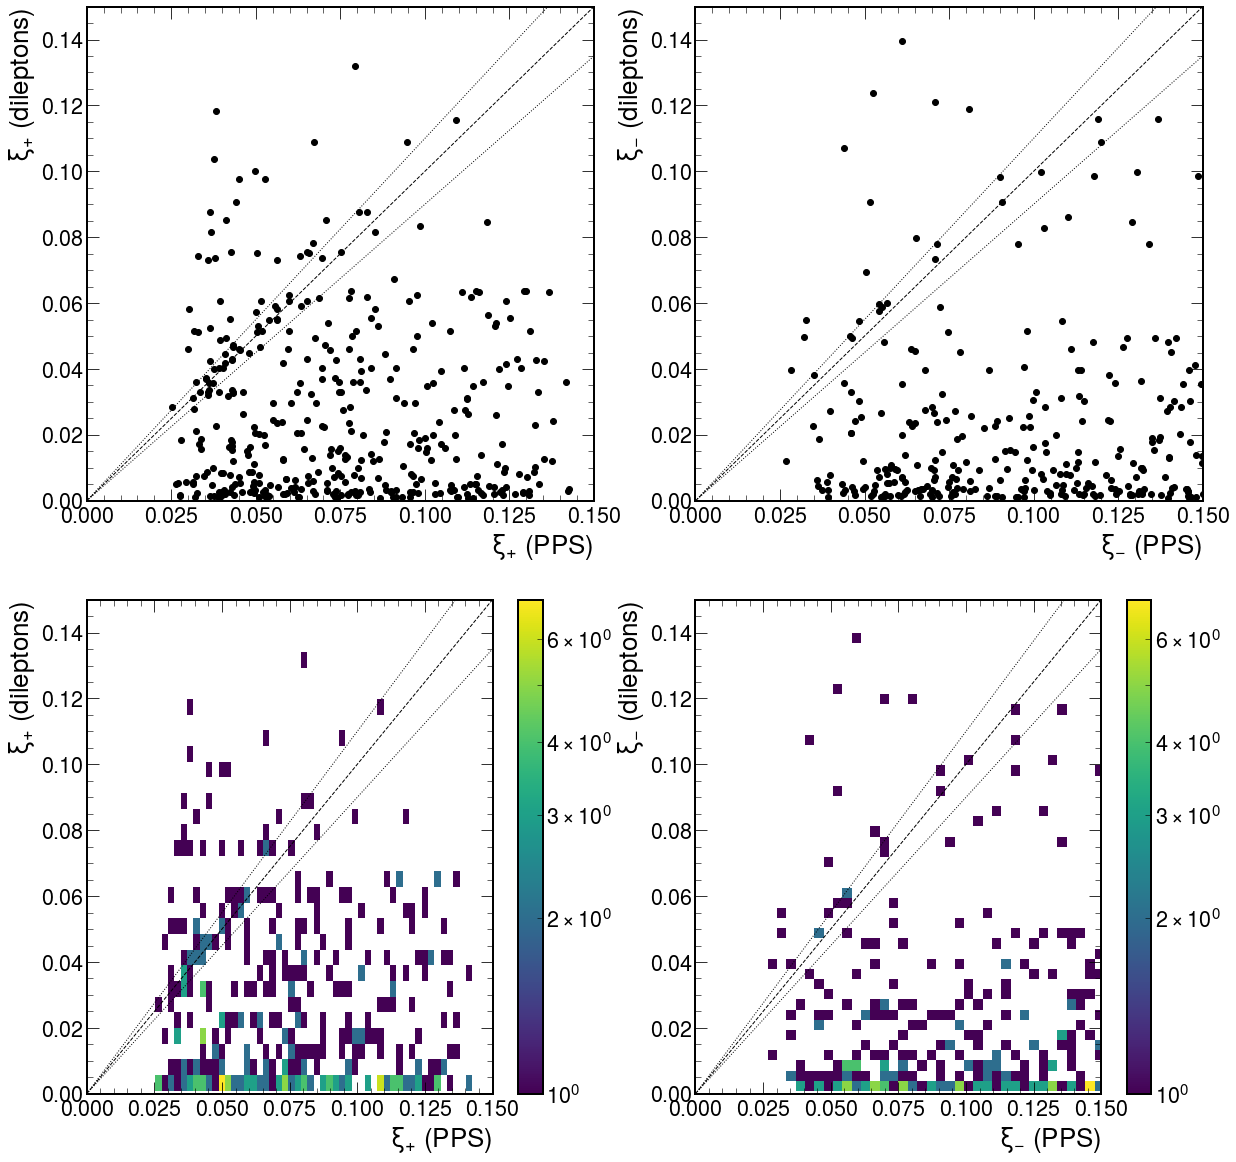

In [28]:
#MASK EVENTS WITH TWO LEPTONS PRODUCED BACK TO BACK EXCLUSEVILY
msk_data = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["PV_ndof"] <= 10 )

#in addiitonl we will focus only on MultiRP reconstruction
proton_selection = "MultiRP" # "SingleRP" or "MultiRP"

#compute xi
ComputeXi(df_data)

#plot correlations:
Plot2DScatter(df_data, mask=msk_data, proton_selection=proton_selection)

In [29]:
# add new variables to dataframes for possitivle and negative xi's :
data_mask_pos = msk_data & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
data_mask_neg = msk_data & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

df_data['delxi_pos'] = (1 - df_data[ "Xi" ] / df_data[ "recXi_pos" ])
df_data['delxi_neg'] = (1 - df_data[ "Xi" ] / df_data[ "recXi_neg" ])

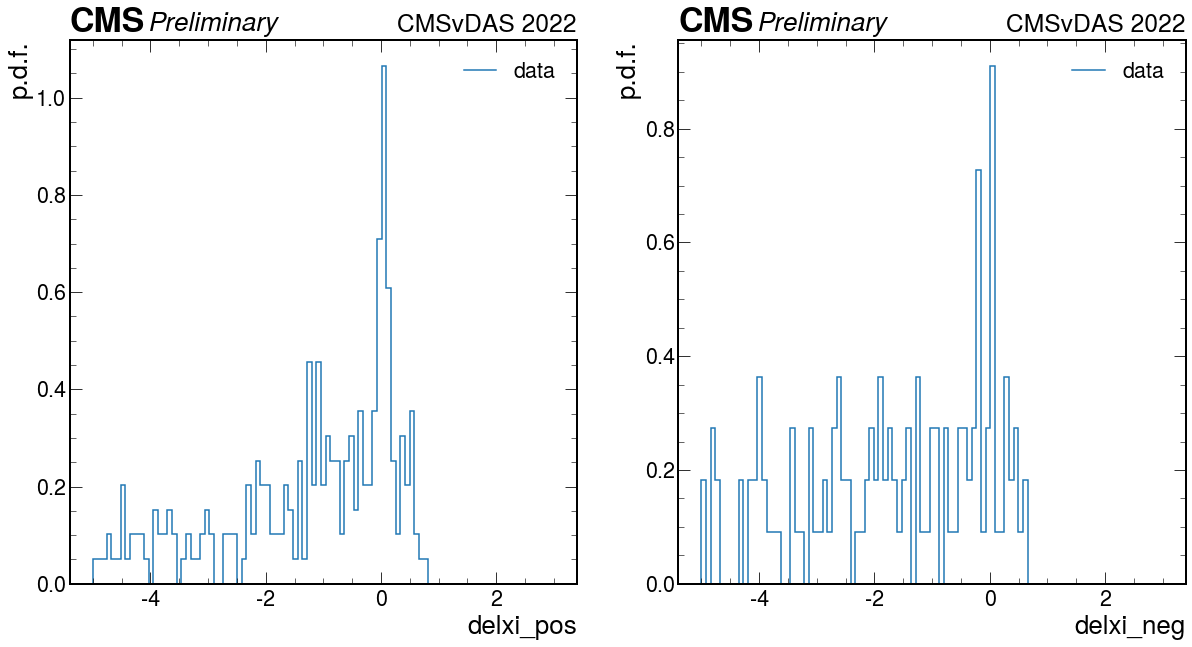

In [30]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
PlotFromDF('delxi_pos',-5,3,100,[df_data[ data_mask_pos ]],['data'],axes[0], log=False)
PlotFromDF('delxi_neg',-5,3,100,[df_data[ data_mask_neg ]],['data'],axes[1], log=False)

### Compare data to signal + background

Before starting this section read [SWGuideCMSDataAnalysisSchoolCERN2020TaggedProtonsLongExercise#Background_modeling](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolCERN2020TaggedProtonsLongExercise#Background_modeling)

Our background estimation method relies on a data-driven approach. We take all data events with at least one tagged protons in this approach, and we mix the proton information between the data events. This will produce similar distribution as the combinatorial background (where one or two of the tagger protons originating from pileup interaction, therefore it is not correlated with the central detector event. 

We'll make a plot of the difference between the $\xi$ reconstructed from PPS and the one reconstructed from the dilepton system.

NOTE: at this stage, we will use skimmed samples. Skim cuts are defined in [select_events.py#L73](https://github.com/CMSDAS/pps-long-exercise/blob/DAS2022/select_events.py#L73)

In [ ]:
#Load the data samples into the dataframes (takes some time)
df_bkg={}
eras=['B']
#eras=['B','C','D','E','F'] #uncooment to process all data
for x in eras:
    df_bkg[x] = GetData(PATH+'/output-UL2018{}-{}-Rand20-skim.h5'.format(x,stream))
    df_bkg[x]['era']=x
    print('output-UL2018{}-{}-Rand20-skim shape = {}'.format(x,stream,df_bkg[x].shape))

#combine all into a single one
df_bkg=pd.concat([df_bkg[x] for x in eras])

In [ ]:
# selection cuts (NOTE: the background is already skimmed)
msk_data = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands_v2"] <= 3 )
msk_bkg = ( df_bkg["InvMass"] >= 110. ) & ( df_bkg["Acopl"] <= 0.009 ) & ( df_bkg["ExtraPfCands_v2"] <= 3 )

# Calculate xi(ll) for background
ComputeXi(df_bkg)

#Make plots
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

bins_ = 40
range_ = (-5.,3.)
resample_factor = 20


counts={}
errors={}
for arm in [0,1]:

    xi_dil='XiMuMuPlus' if arm==0 else 'XiMuMuMinus'
    
    #build the differences for the data
    msk_data_arm = msk_data & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == arm )
    delta = ( 1. - df_data[ "Xi" ][ msk_data_arm ] / df_data[ xi_dil ][ msk_data_arm ] )
    counts[arm], bin_edges = np.histogram( delta, bins=bins_, range=range_ )
    errors[arm] = np.sqrt( counts[arm] )
    bin_centers = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
    axes[arm].errorbar(bin_centers, counts[arm], yerr=errors[arm], fmt='o', label='Data')
        
    print('Arm=',arm,'Data counts=',counts[arm], 'bin edges=',bin_edges )

    #build the differences for the background
    msk_bkg_arm = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & ( df_bkg["Arm"] == arm )
    weights = None
    if resample_factor > 1:
        weights = np.full_like( df_bkg[ "Xi" ][ msk_bkg_arm ], ( 1./resample_factor ) )
    delta_bkg = ( 1. - df_bkg[ "Xi" ][ msk_bkg_arm ] / df_bkg[ xi_dil ][ msk_bkg_arm ] )
    axes[arm].hist( delta_bkg, bins=bins_, range=range_, weights=weights, label='Background' )

    
#final tweak to have both y-axis at the same scale showing all data
total_counts=np.concatenate( [counts[0],counts[1]] )
total_errors=np.concatenate( [errors[0], errors[1]] )
idx_ymax_ = np.argmax( total_counts )
y_max = total_counts[idx_ymax_] + 2*total_errors[idx_ymax_]
print ( "y max. = {}".format(y_max) )
for arm in [0,1]:
    axes[arm].set_ylim( top=y_max )
    sgn='+' if arm==0 else '-'
    axes[arm].set_xlabel(r'$[\Delta\xi/\xi(\ell\ell)]_{%s}$'%(sgn))
    axes[arm].set_ylabel('Events')
    axes[arm].legend(loc='best')

### Correlation plots on the background samples - optimization

<b>TASK D</b>


produce $\Delta\xi$ correlation plots from the background sample and optimize selection cut

In [ ]:
bkg_mask_pos = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & ( df_bkg["Arm"] == 0 )
bkg_mask_neg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & ( df_bkg["Arm"] == 1 )

df_bkg['delxi_pos'] = (1 - df_bkg[ "Xi" ] / df_bkg[ "recXi_pos" ])
df_bkg['delxi_neg'] = (1 - df_bkg[ "Xi" ] / df_bkg[ "recXi_neg" ])

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
labels=['background','exclusive di-$\ell$']
PlotFromDF('delxi_pos',-5,3,100,[df_bkg, df_signal],labels,axes[0], log=False)
PlotFromDF('delxi_neg',-5,3,100,[df_bkg, df_signal],labels,axes[1], log=False)

Using the codes developed in [Event-selection-optimization.ipynb](https://nbviewer.jupyter.org/github/cmsdas/pps-long-exercise/blob/master/Event-selection-optimization.ipynb) adapting the following cut:

$$ \Delta\xi < cut  $$ and  $$ \Delta\xi > -cut  $$

In [ ]:
# function that computes signal significance
def computeZ(Ns, Nb):
    return Ns/np.sqrt(Nb)

# function that computes event yields
def ComputeYields(s, b, cut):
    Ns = s[((s['delxi_pos']<cut) & (s['delxi_pos']>-cut)) | ((s['delxi_neg']<cut) & (s['delxi_neg']>-cut))].groupby('EventNum').ngroups
    Nb = b[((b['delxi_pos']<cut) & (b['delxi_pos']>-cut)) | ((b['delxi_neg']<cut) & (b['delxi_neg']>-cut))].groupby('EventNum').ngroups
    return Ns, Nb


In [ ]:
#Relative significance for a single cut value (example for Acopl<0.09):
Nscut, Nbcut = ComputeYields(df_signal,df_bkg, 0.5)
Nsnocut, Nbnocut = ComputeYields(df_signal,df_bkg, 999999999)
sig_ratio = computeZ(Nscut, Nbcut) / computeZ(Nsnocut, Nbnocut)
print('Relative significance = ',sig_ratio) 
print('Signal acceptance = ',Nscut/Nsnocut)